# Dogo Breeds classifier 

![](./images/background.jpg)

### You might think that recognizing dog breeds is an easy task for most of the people. Well not really.

### For instance take a look that these two images of a `Curly Coated Retriever` and an <br><br>`American Water Spaniel`.

![alt_text](./display_images/diff1.png)

### Look very similar don't they? Or what about these two?

![alt_text](./display_images/diff2.png)

### Doesn't look se easy now right does it? Let's go one step further and take a look at the next two images of <br><br>`American Staffordshire Terrier` with different light intensity and environment.

![alt_text](./display_images/diff3.png)

 ### These two images are of same breed! The classification task would be very hairy to solve for a computer if <br><br>even as humans we can easily go wrong most of the times. So let's see how we can deduce to the <br><br>most efficient way of classifying these breeds.


## First Let's import all the necessary modules
<br>

In [1]:
import random
import pandas as pd
from PIL import Image, ImageFile
from os import path, getcwd, listdir, environ
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121, Xception, MobileNetV2, InceptionV3
import h5py as h5 

# from sklearn.metrics import classification_report
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

%matplotlib inline
tf.random.set_seed(1)
environ['PYTHONHASHSEED']=str(1)
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Data Preprocessing and visualization
<br>

In [2]:
train_dir = getcwd() + '/images/train/'
test_dir = getcwd() + '/images/test/'
breeds = listdir(train_dir)

seed = 42
img_size = 299
batch_size = 32

In [3]:
def read_img(file_loc, size):
    img = Image.open(file_loc)
    return img

def print_random_images():
    fig=plt.figure(figsize=(10, 10))
    columns = 4
    rows = 4
    title = ""
    
    for i in range(1, columns*rows +1):
        cat = random.choice(breeds)
        dir_path = path.join(train_dir, cat)
        loc = path.join(dir_path, random.choice(listdir(dir_path)))
        img = read_img(loc, 299)
        title = cat
            
        axes = fig.add_subplot(rows, columns, i, title=title)
        fig.tight_layout(pad=1.0)
        axes.axis('off')
        title = ""
    
        plt.imshow(img)
        
    plt.show()

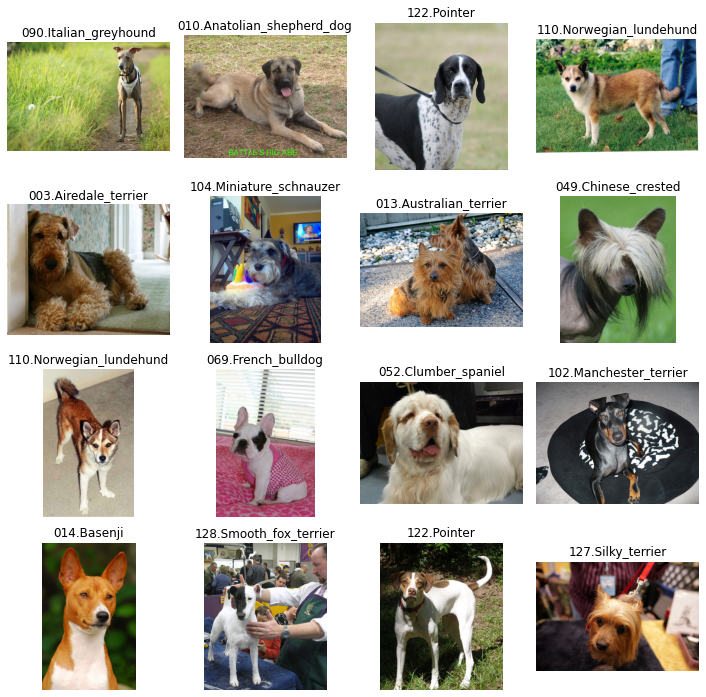

In [4]:
print_random_images()

* Let's print some random images 

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (img_size, img_size),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                            target_size = (img_size, img_size),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 6680 images belonging to 133 classes.
Found 836 images belonging to 133 classes.


### Conclusion 

* With a simple 4 layered ConvNet model after ___ epochs we get __ % train accuracy and __ % validation accuracy.
<br><br>
* This is not good enough considering us humans can reach atleat 80% to 90% accuracy.
<br><br>
* As we know that the model is trained by maximizing it's accuracy on training dataset but it's performance is determined on its ability to perform well on unknown data.
<br><br>
* The reason for a bigger difference in loss and accuracy trends between training and validation datasets is because the model is overfitting. One of the main reason for this to happen is because our dataset is too small to find differences between 133 different breeds of dogs. Also there's a lot of noise in the dataet as you can see some images have more than one dog or some images also have human faces in them.
<br><br>
* In machine learning, overfitting occurs when a learning model customizes itself too much to describe the relationship between training data and the labels. Overfitting tends to make the model very complex by having too many parameters. By doing this, it loses its generalization power, which leads to poor performance on new data.
<br><br>
*  In this situation our model just trying to memorize the training data as instead of trying to generalize from patterns observed in the training data.

## Part 3 ~> `Transfer Learning - Xception Network`

In [6]:
base_model = Xception(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False
    
# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(133, activation='softmax')(x)

# this is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [7]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=25,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
 47/209 [=====>........................] - ETA: 17:05 - loss: 2.7557 - accuracy: 0.4302

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

In [ ]:
valid_generator.reset()
predictions=model2.predict_generator(valid_generator,steps=len(valid_generator))
y=np.argmax(predictions,axis=1)

print('Classification Report')
report=classification_report(y_true=valid_generator.classes,y_pred=y,target_names=valid_generator.class_indices)
print(report)

In [ ]:
print('Confusion Matrix')

cm=confusion_matrix(valid_generator.classes,y)
df=pd.DataFrame(cm,columns=valid_generator.class_indices)
plt.figure(figsize=(80,80))
sns.heatmap(df,annot=True)